In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [10]:
M = 4 # Number of Spiking motifs
N = 20 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 20 # hz
pg_fr = 4 # hz
background_noise_fr = 5/M # hz

np.random.seed(41)

In [11]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [12]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

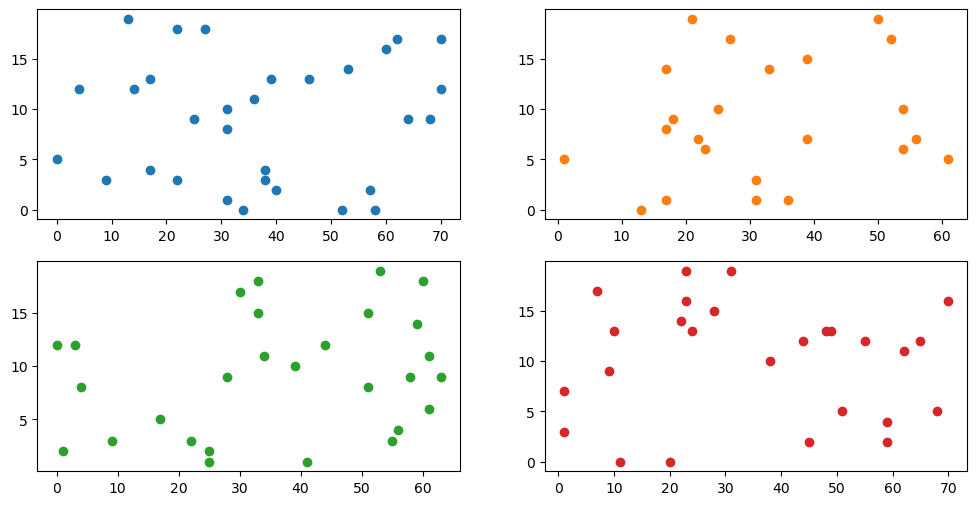

In [13]:

if disp_figs:
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i]) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [14]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [15]:
B_sparse

(array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3], dtype=int64),
 array([132, 748, 870, 917, 962,  82, 424, 533,  28, 381, 384, 108, 250,
        341, 364, 374, 458], dtype=int64))

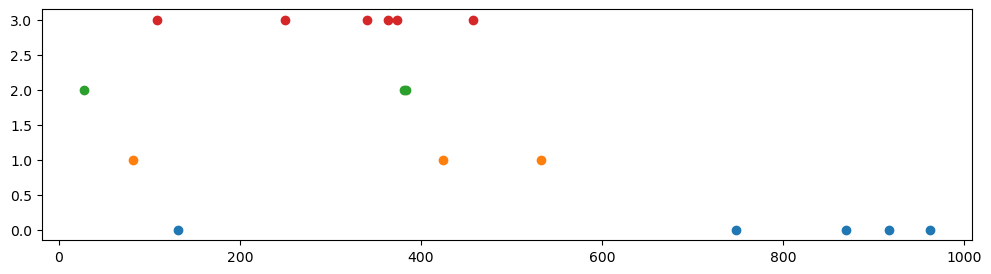

In [16]:
plt.figure(figsize=(12,3))
[plt.scatter(B_sparse[1][B_sparse[0]==i],B_sparse[0][B_sparse[0]==i],c=colors[i]) for i in range(4)]
plt.show()

# Convolve the PG kernels with the PG firing times

In [33]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M)
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1][A_dense[...,-1]<background_noise_fr] =1
A_dense[...,-1][A_dense[...,-1]!=1] = 0
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(20, 1071)

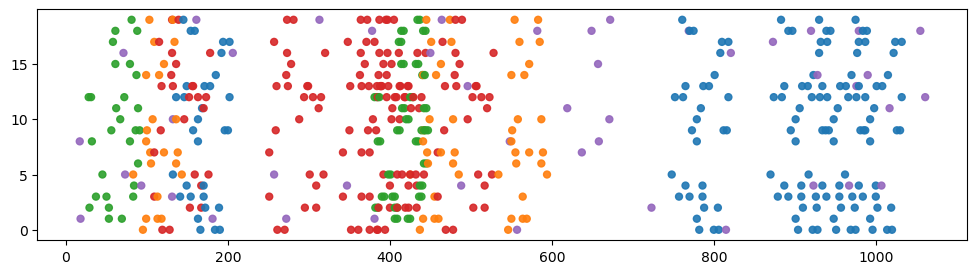

In [36]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

In [207]:
detect(K_dense,A_dense):
    
    returns

SyntaxError: invalid syntax (902579885.py, line 1)

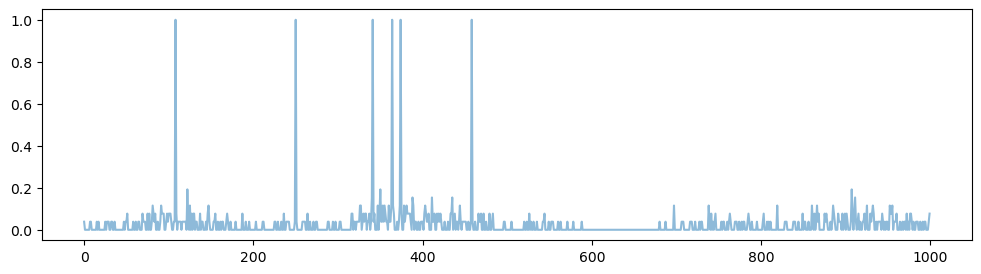

In [235]:
test = np.zeros((T,4))
%matplotlib inline
for j in range(4):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
plt.plot(test[:,3],alpha=0.5)

So the y-axis here corresponds to the proportion of overlapping events. 1 -> is 100%. This is where the bias comes in I think...

# Logistic Regression!!

$$p(t,b)=\sigma(K_{\beta}(b) + \sum_{a \in S^b,0\leq\delta\leq D} A(a,t-\delta)*(K^T_a(b,\delta))$$

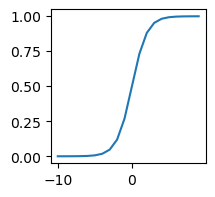

In [209]:
sigmoid = lambda x : 1 / (1 + np.e**(-x))
plt.figure(figsize=(2,2))
plt.plot(np.arange(-10,10), sigmoid(np.arange(-10,10)))
plt.show()

In [210]:
'''
So the bias term and the weights need to be initialized (randomly)

B_dense is the matix that defines when STM's occur, and there for it is y (the answer) of size (T)
x should be a new matrix of size (NxDxT) right?

x=A_dense[:,:D] # this is the evidence for y_0
x = A_dense[:,1:D+1] # this is the evidence for y_1

'''

"\nSo the bias term and the weights need to be initialized (randomly)\n\nB_dense is the matix that defines when STM's occur, and there for it is y (the answer) of size (T)\nx should be a new matrix of size (NxDxT) right?\n\nx=A_dense[:,:D] # this is the evidence for y_0\nx = A_dense[:,1:D+1] # this is the evidence for y_1\n\n"

In [211]:
num_STM = B_dense.shape[0]
x = [np.zeros((T,N,D)) for k in range(num_STM)]
y = [np.zeros((T)) for k in range(num_STM)]
for j in range(num_STM):
    for i in range(T):
        x[j][i,...] = A_dense[:,i:D+i]
    y[j] = B_dense[j,:]
    x[j]=x[j].reshape(x[j].shape[0],x[j].shape[1]*x[j].shape[2])
x[0].shape, y[0].shape

((1000, 1420), (1000,))

# Pytorch

In [212]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


In [213]:
#logistic regression class
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
    
    #sigmoid transformation of the input 
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

accuracy: 1.0000ss = 0.0021
accuracy: 0.9960ss = 0.0022
accuracy: 0.9960ss = 0.0022
accuracy: 0.9960ss = 0.0022


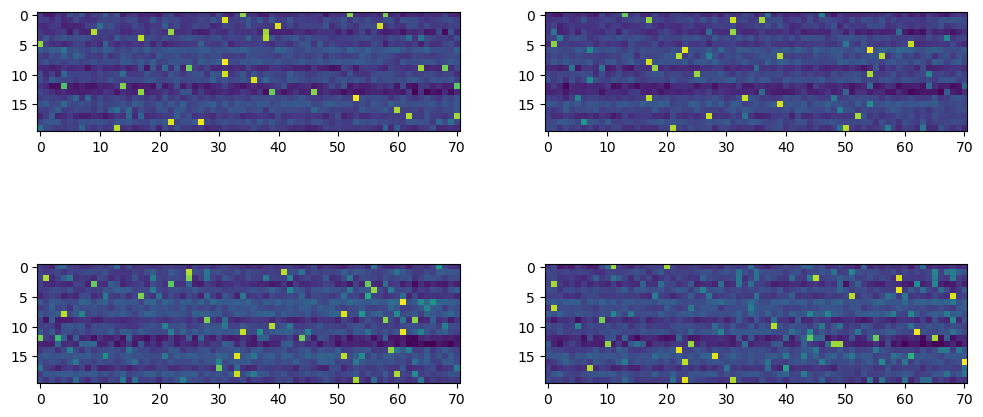

In [267]:
weights = [np.zeros_like(x[0]) for k in range(num_STM)]
detections = np.zeros((T,num_STM))
for j in range(num_STM):
    x_train, x_test, y_train, y_test= train_test_split(x[j], y[j], test_size= 0.25, random_state=0) 
    x_train = torch.from_numpy(x_train.astype(np.float32))
    x_test = torch.from_numpy(x_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32))
    
    y_train = y_train.view(y_train.shape[0], 1)
    y_test = y_test.view(y_test.shape[0], 1)
    
    n_samples, n_features = x[j].shape
    
    lr = LogisticRegression(n_features)
    
    num_epochs = 50000                                       
    # Traning the model for large number of epochs to see better results  
    learning_rate = 0.01                               
    criterion = nn.BCELoss()                                
    # We are working on lgistic regression so using Binary Cross Entropy
    optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate)      
    # Using ADAM optimizer to find local minima   
          
    for epoch in range(num_epochs):
        y_pred = lr(x_train)
        loss = criterion(y_pred, y_train)             
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (epoch+1) % 20 == 0:                                         
            # printing loss values on every 10 epochs to keep track
            print(f'epoch: {epoch+1}, loss = {loss.item():.4f}',end='\r')
        
    with torch.no_grad():
        y_predicted = lr(x_test)
        y_predicted_cls = y_predicted.round()
        acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
        print(f'accuracy: {acc.item():.4f}')
        
        detections[:,j] = lr(torch.from_numpy(x[j].astype(np.float32))).detach().numpy().round().reshape(n_samples)

    weights[j] = lr.linear.weight.detach().numpy()
    weights[j] = weights[j].T.reshape(N,D)
        

fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
ax['A'].imshow(weights[0])
ax['B'].imshow(weights[1])
ax['C'].imshow(weights[2])
ax['D'].imshow(weights[3])


In [269]:
detections = np.array(detections)
detections = detections.reshape(1000,4)
detections.shape

(1000, 4)

In [270]:
np.where(detections)

(array([ 28,  82, 108, 132, 250, 341, 374, 381, 458, 533, 748, 870, 917,
        962], dtype=int64),
 array([2, 1, 3, 0, 3, 3, 3, 2, 3, 1, 0, 0, 0, 0], dtype=int64))

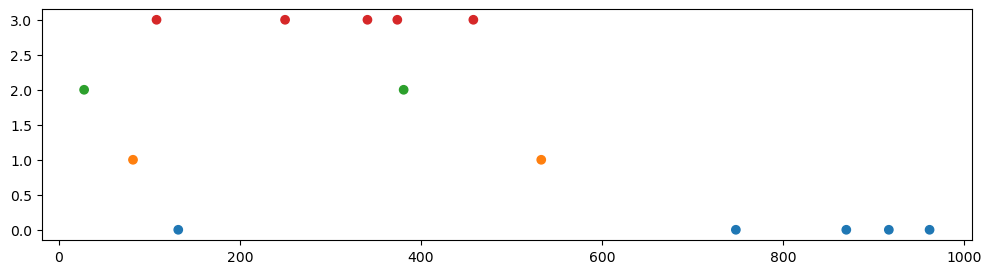

In [271]:
plt.figure(figsize=(12,3))
plt.scatter(*np.where(detections),c=colors[np.where(detections)[1]])
# plt.plot(detections[0].round())
# plt.plot(detections[1].round())
# plt.plot(detections[2].round())
# plt.plot(detections[3].round())
plt.show()

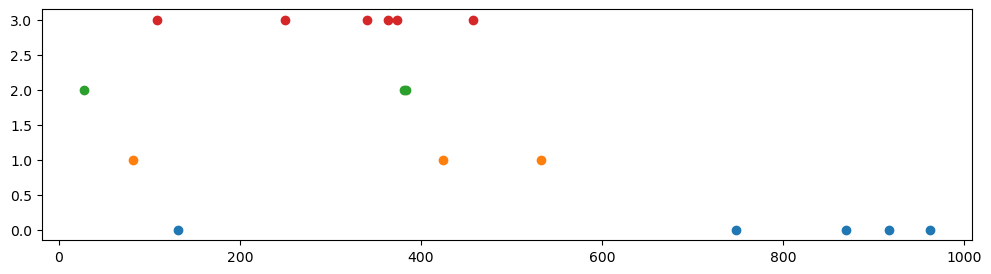

In [246]:
plt.figure(figsize=(12,3))
[plt.scatter(B_sparse[1][B_sparse[0]==i],B_sparse[0][B_sparse[0]==i],c=colors[i]) for i in range(4)]
plt.show()

# sklearn

In [290]:
w= []
y_pred = []
from sklearn.linear_model import LogisticRegression  
classifier= LogisticRegression(random_state=0)  

for j in range(4):

    x_train, x_test, y_train, y_test= train_test_split(x[j], y[j], test_size= 0.25, random_state=0) 
    x_train = torch.from_numpy(x_train.astype(np.float32))
    x_test = torch.from_numpy(x_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32))

    classifier.fit(x_train, y_train.ravel()) 
    y_pred.append(classifier.predict(x[j]))
    
    w.append(classifier.coef_)
    w[-1] = w[-1].T
    w[-1] = w[-1].reshape(N,D)
w = np.array(w)
y_pred = np.array(y_pred)

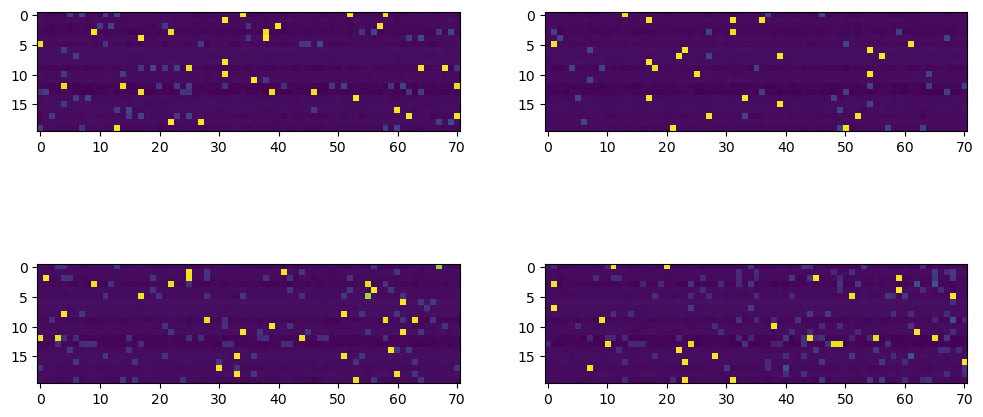

In [289]:
fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
ax['A'].imshow(w[0])
ax['B'].imshow(w[1])
ax['C'].imshow(w[2])
ax['D'].imshow(w[3])

In [293]:
detections.shape, y_pred.shape

((1000, 4), (4, 1000))

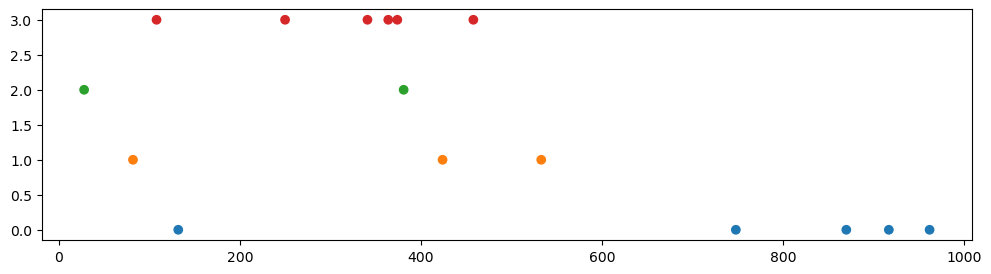

In [296]:
plt.figure(figsize=(12,3))
plt.scatter(*np.where(y_pred.T),c=colors[np.where(y_pred.T)[1]])

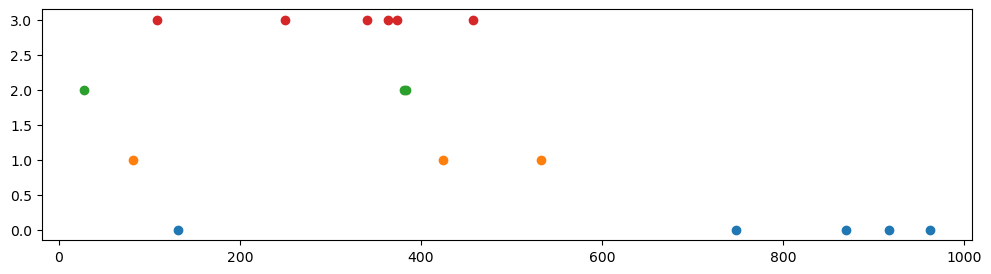

In [297]:
plt.figure(figsize=(12,3))
[plt.scatter(B_sparse[1][B_sparse[0]==i],B_sparse[0][B_sparse[0]==i],c=colors[i]) for i in range(4)]
plt.show()

okay... sklearn's logistic regression funtction is blazing fast, and performs better than pytorch's ... What am I doing wrong lol
